In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
batch_size = 32
seed = 42

In [3]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "./train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "./train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "./test", batch_size=batch_size
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [4]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(
        lowercase, "[%s]" % re.escape(string.punctuation), ""
    )

In [5]:
max_features = 10000
sequence_length = 250

# 단어 → 정수 인덱스 시퀀스로 변환
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [6]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2025-06-29 22:59:42.317593: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [8]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [9]:
# 성능 최적화를 위한 설정
AUTOTUNE = tf.data.AUTOTUNE

# cache: 작은 데이터셋이나 짧은 epoch 반복일 때 매우 유효
# prefetch: 다음 배치를 백그라운드에서 미리 준비
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 16

model = tf.keras.Sequential(
    [
        layers.Embedding(max_features + 2, embedding_dim),  # 정수 to 실수
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),  # 시퀀스 차원(문장길이)을 평균내어 하나의 벡터로 축소
        layers.Dropout(0.2),
        layers.Dense(4),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

In [21]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3799 - sparse_categorical_accuracy: 0.3029 - val_loss: 1.3582 - val_sparse_categorical_accuracy: 0.3394
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3429 - sparse_categorical_accuracy: 0.4059 - val_loss: 1.3086 - val_sparse_categorical_accuracy: 0.5119
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2907 - sparse_categorical_accuracy: 0.4749 - val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.5931
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2155 - sparse_categorical_accuracy: 0.5478 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.6575
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1307 - sparse_categorical_accuracy: 0.6063 - val_loss: 1.0677 - val_sparse_categorical_accuracy: 0.6956


In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0913 - sparse_categorical_accuracy: 0.6809
Loss:  1.0848735570907593
Accuracy:  0.6797500252723694


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

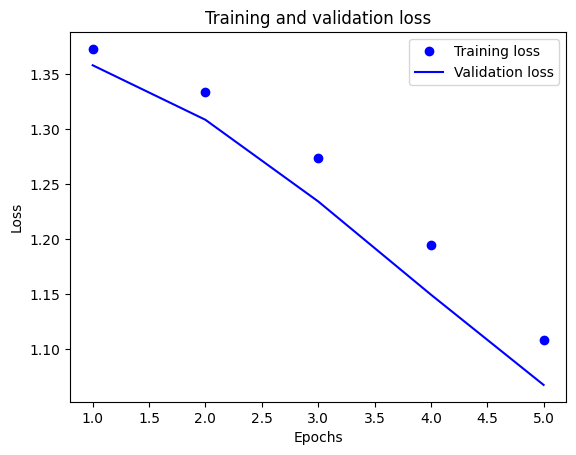

In [26]:
acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

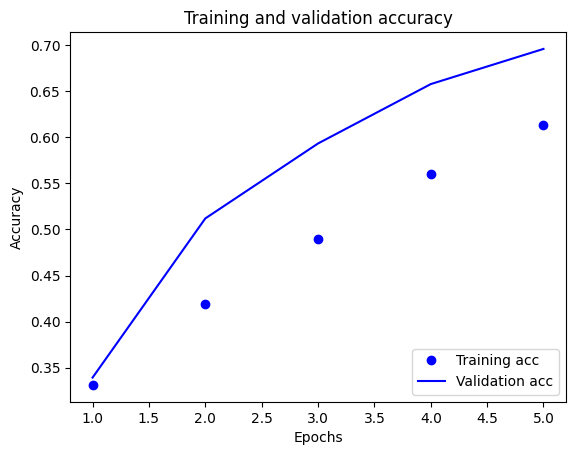

In [27]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [29]:
# 최종 추론 모델
# 문장을 그래도 받아서 추론하는 최종 형태의 모델
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("softmax")]
)

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6819 - loss: 1.0914
0.6797500252723694
